#Import Libraries

In [76]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import Dropout, BatchNormalization

from google.colab import drive

print("Module Loaded.")
print("TensorFlow Version :{}".format(tf.__version__))
print("NumPy Version :{}".format(np.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
TensorFlow Version :2.0.0
NumPy Version :1.17.4
Matplotlib Version :3.1.2


In [77]:
drive.mount('/content/drive')

#data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data/furniture')\
!cp -r /content/drive/Shared\ drives/scsa_2019_b/Project_Ai-KEA/data_resize .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C


In [78]:
data_path = pathlib.Path('/content/data_resize/furniture')

class_name = np.array([item.name for item in data_path.glob('*')])
print(class_name)

['standing_lamp' 'entertainment_center' 'table' 'makeup_table' 'curtain'
 'bed' 'bookshelves' 'sofa' 'chair' 'rug']


# Resize Image

#ImageGenerator

In [0]:
img_size = 112
batch_n = 200


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                #horizontal_flip=True, 
                                #vertical_flip=True,
                                #rotation_range=30,
                                #zoom_range=0.1,
                                #brightness_range=[0.8,1.2],
                                validation_split=0.2,
                                rescale=1./255)

Found 3709 images belonging to 10 classes.
Found 923 images belonging to 10 classes.
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=429x400 at 0x7F502DE80A58>


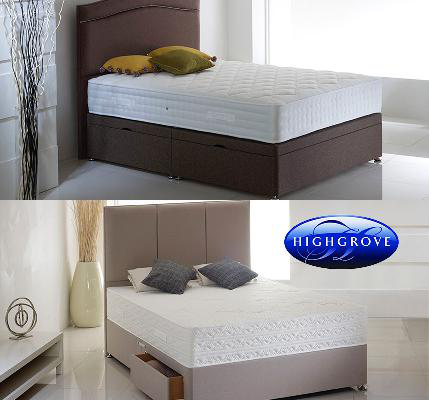

In [92]:
train_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='training')
test_data_generate = image_generator.flow_from_directory(
                        directory=str(data_path),
                        batch_size=batch_n,
                        shuffle=True,
                        target_size=(img_size, img_size),
                        classes = list(class_name),
                        subset='validation')

data_pathd = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture/bed')

images = list(data_pathd.glob('*.jpg'))
img = tf.keras.preprocessing.image.load_img(images[15]) 
print(img)
img


#Load VGG

import model

In [93]:
import tensorflow.keras.applications.vgg16 as vgg16

model_vgg = vgg16.VGG16(
    weights="imagenet", 
    include_top=False,    # dense layer 이 후는 제외
    input_tensor=tf.keras.layers.Input(shape=(img_size, img_size, 3))
    #input_tensor=keras.layers.Input(shape=(49, 49, 3))
)

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

##fine tuning

freeze layers

In [94]:
# slicing which layers not to train
for layer in model_vgg.layers[:] :
  layer.trainable = False

for layer in model_vgg.layers :
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f502dee5f98> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502dee5358> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502de80828> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f502e0ecba8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502e0ecc88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502e141438> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f502e14c710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502e14c7f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f502e15df28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5022d3a240> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5022d47518> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

make ai-kea model

In [95]:
ai_kea = tf.keras.models.Sequential()

ai_kea.add(model_vgg)

# Here add new layers
ai_kea.add(Flatten())
ai_kea.add(Dense(1024, activation='relu'))
#model_fine.add(keras.layers.Dropout(0.5))
#model_fine.add(keras.layers.LeakyReLU(alpha=0.1))
ai_kea.add(BatchNormalization())   # 필히 사용할 것
ai_kea.add(Dense(10, activation='softmax'))
ai_kea.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              4719616   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                10250     
Total params: 19,448,650
Trainable params: 4,731,914
Non-trainable params: 14,716,736
_________________________________________________________________


#model compile & train

In [0]:
epoch_n = 70

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [99]:
ai_kea.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(epoch_n)),
              metrics=['accuracy'])

Learning rate:  0.001


In [100]:
history = ai_kea.fit_generator(
    train_data_generate,
    epochs = epoch_n,
    validation_data = test_data_generate
)

Epoch 1/70
19/19 [==============================] - 37s 2s/step - loss: 1.6563 - accuracy: 0.5319 - val_loss: 1.5649 - val_accuracy: 0.4680
Epoch 2/70
19/19 [==============================] - 33s 2s/step - loss: 0.9507 - accuracy: 0.6924 - val_loss: 1.3622 - val_accuracy: 0.5233
Epoch 3/70
19/19 [==============================] - 33s 2s/step - loss: 0.7963 - accuracy: 0.7390 - val_loss: 1.1714 - val_accuracy: 0.5753
Epoch 4/70
19/19 [==============================] - 34s 2s/step - loss: 0.7353 - accuracy: 0.7525 - val_loss: 1.2635 - val_accuracy: 0.5796
Epoch 5/70
19/19 [==============================] - 34s 2s/step - loss: 0.6894 - accuracy: 0.7703 - val_loss: 1.2075 - val_accuracy: 0.6035
Epoch 6/70
19/19 [==============================] - 34s 2s/step - loss: 0.6693 - accuracy: 0.7751 - val_loss: 1.0325 - val_accuracy: 0.6761
Epoch 7/70
19/19 [==============================] - 34s 2s/step - loss: 0.6059 - accuracy: 0.7962 - val_loss: 1.1568 - val_accuracy: 0.6046
Epoch 8/70
19/19 [==

In [101]:
print(np.max(history.history['val_accuracy']))

0.7258938
